# Relation Extraction using NLP and Neural Networks modelling ( BiLSTM + CNN with Multi-head Attention )

### Importing necessary libraries for natural language processing and machine learning tasks

In [3]:
# Importing SpaCy for advanced natural language processing tasks
import spacy
from spacy import displacy
from spacy.tokens import DocBin

# Importing essential libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing NLTK for basic natural language processing tasks
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Importing libraries for machine learning and deep learning
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer, Input, Embedding, Dropout, Conv1D, Bidirectional, LSTM, Activation, GlobalMaxPooling1D, Dense, Permute, Lambda, concatenate, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adadelta
import tensorflow.keras.backend as K
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Mounting Google Drive if working in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Installing the datasets library using pip
!pip install datasets

### Importing and Loading the SemEval dataset

In [5]:
# Importing the load_dataset function from the datasets library
from datasets import load_dataset

# Loading the SemEval 2010 Task 8 dataset using the load_dataset function
dataset = load_dataset("sem_eval_2010_task_8")

c:\Users\Kashish\1.Kashish\Manchester\Semester 2\Text Mining\Project\tmenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# Printing the loaded dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'relation'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['sentence', 'relation'],
        num_rows: 2717
    })
})


In [7]:
# Extracting the training and testing data from the loaded dataset
train_data = dataset["train"]
test_data = dataset["test"]

In [27]:
# Displaying the testing data
test_data

Dataset({
    features: ['sentence', 'relation'],
    num_rows: 2717
})

### Convert Train_data to a DataFrame

In [9]:
# Converting the training data to a DataFrame using pandas
train_df = pd.DataFrame(train_data)
train_df

,sentence,relation
0,The system as described above has its greatest...,3
1,The <e1>child</e1> was carefully wrapped and b...,18
2,The <e1>author</e1> of a keygen uses a <e2>dis...,11
3,A misty <e1>ridge</e1> uprises from the <e2>su...,18
4,The <e1>student</e1> <e2>association</e2> is t...,12
...,...,...
7995,When the <e1>notice</e1> is sent by <e2>fax</e...,18
7996,The <e1>herbicide</e1> is derived from a natur...,8
7997,"To test this, we placed a kitchen <e1>match</e...",6
7998,The farmers and city officials in the region h...,18


### Generating Word Cloud for Initial Training Data


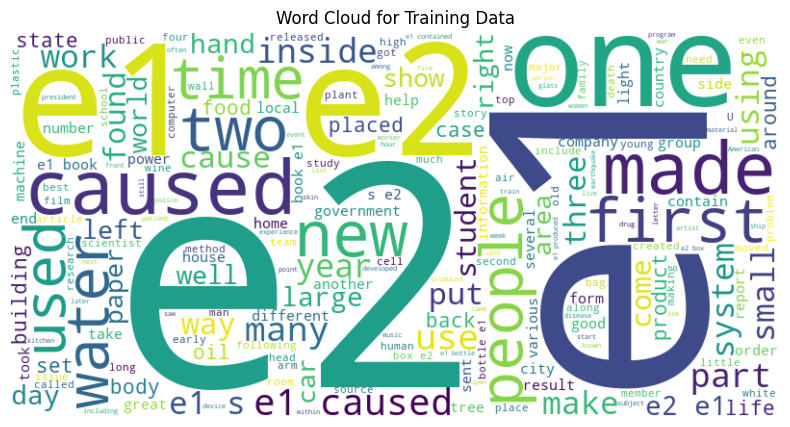

In [10]:
# Concatenating all sentences into a corpus of text
all_sentences_train = " ".join(train_df["sentence"])

# Create word cloud for training data
wordcloud_train = WordCloud(width=800, height=400, background_color="white")
wordcloud_train.generate(all_sentences_train)

#Display the word cloud for training data
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.title("Word Cloud for Training Data")
plt.axis("off")
plt.show()

### Entity Extraction from Sentences

Function to extract entities and their indices from cleaned sentence.

Args:
- sentence (str): The cleaned sentence with entity tags.

Returns:
- e1 (str): The text of the first entity.
- e2 (str): The text of the second entity.
- e1_index (int): The starting index of the first entity.
- e2_index (int): The starting index of the second entity.

In [11]:
# Function to extract entities and their indices from cleaned sentence
def extract_entities(sentence):
    # Using regular expressions to find the text between <e1> and </e1> tags and <e2> and </e2> tags
    e1_match = re.search(r'<e1>(.*?)<\/e1>', sentence)
    e2_match = re.search(r'<e2>(.*?)<\/e2>', sentence)

    # Extracting entity texts or setting empty string if not found
    e1 = e1_match.group(1) if e1_match else ''
    e2 = e2_match.group(1) if e2_match else ''

    # Extracting entity indices or setting -1 if not found
    e1_index = e1_match.start() if e1_match else -1
    e2_index = e2_match.start() if e2_match else -1

    return e1, e2, e1_index, e2_index

# Apply the function to each row in the DataFrame
train_df['e1'], train_df['e2'], train_df['e1_index'], train_df['e2_index'] = zip(*train_df['sentence'].apply(extract_entities))


In [12]:
train_df.head(3)

,sentence,relation,e1,e2,e1_index,e2_index
0,The system as described above has its greatest...,3,configuration,elements,73,107
1,The <e1>child</e1> was carefully wrapped and b...,18,child,cradle,4,60
2,The <e1>author</e1> of a keygen uses a <e2>dis...,11,author,disassembler,4,39


## Data Cleaning

This function takes a DataFrame containing training data as input and returns a list of tokenized sentences. Each sentence is cleaned by converting it to lowercase, replacing entity tags with special tokens, and removing non-alphanumeric characters. Finally, the sentences are tokenized using NLTK's word_tokenize function.

Steps involved:

1. **Sentence Extraction**: For each row, it extracts the sentence and removes any leading or trailing quotes.
2. **Lowercasing**: It converts the extracted sentence to lowercase using the lower() method.
3. **Entity Tag Replacement**: It replaces <e1>, </e1>, <e2>, and </e2> tags with special tokens (E1_START, E1_END, E2_START, E2_END) using the replace() method.
4. **Noise Removal**: It removes non-alphanumeric characters from the sentence using regular expressions (re.sub()).
5. **Tokenization**: It tokenizes the cleaned sentence using NLTK's word_tokenize() function.
6. **Storing Tokens**: It stores the tokenized sentence in the sentences list.
7. **Return**: Finally, it returns the list of tokenized sentences (sentences).

In [13]:
def clean_and_tokenize(train_df):
    """
    Function to clean and tokenize sentences in the DataFrame.

    Args:
    - train_df (DataFrame): DataFrame containing the training data.

    Returns:
    - sentences (list of lists): Tokenized sentences.
    """
    sentences, relations = [], []

    for i, row in train_df.iterrows():
        sentence = train_df['sentence'][i][0:-1]  # Remove leading/trailing quotes
        #label = train_df['relation'][i]

        # Convert Text to Lowercase
        sentence = sentence.lower()

        # Replace <e1> and </e1> tags with tokens
        sentence = sentence.replace("<e1>", " E1_START ").replace("</e1>", " E1_END ")
        # Replace <e2> and </e2> tags with tokens
        sentence = sentence.replace("<e2>", " E2_START ").replace("</e2>", " E2_END ")

        # Remove Noise
        sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)


        # Tokenize the sentence
        tokens = word_tokenize(sentence)

        # Store preprocessed sentence and label
        sentences.append(tokens)
        #relations.append(label)

    return sentences


In [14]:
# Access the tokenized representation of the second sentence in the preprocessed training data
sentences = clean_and_tokenize(train_df)
sentences[1]

['the',
 'E1START',
 'child',
 'E1END',
 'was',
 'carefully',
 'wrapped',
 'and',
 'bound',
 'into',
 'the',
 'E2START',
 'cradle',
 'E2END',
 'by',
 'means',
 'of',
 'a',
 'cord']

In [15]:
# Apply the clean_and_tokenize function to preprocess and tokenize each sentence in the training data
train_df['cleaned_tokens'] = clean_and_tokenize(train_df)

In [16]:
# Display the first 3 rows of the DataFrame after preprocessing
train_df.head(3)

,sentence,relation,e1,e2,e1_index,e2_index,cleaned_tokens
0,The system as described above has its greatest...,3,configuration,elements,73,107,"[the, system, as, described, above, has, its, ..."
1,The <e1>child</e1> was carefully wrapped and b...,18,child,cradle,4,60,"[the, E1START, child, E1END, was, carefully, w..."
2,The <e1>author</e1> of a keygen uses a <e2>dis...,11,author,disassembler,4,39,"[the, E1START, author, E1END, of, a, keygen, u..."


## Dependency Pasre Tree Structure

In [ ]:
#These commands install the SpaCy library and download the English language model required for processing text.
pip install spacy
python -m spacy download en_core_web_sm

### Dependency Parsing Visualization after processing the sentences using SpaCy
This code block showcases how to process sentences, visualize dependency parse trees, and extract token dependency information using the SpaCy library in Python.

In [20]:
# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Sample sentences
sentences = [
    "People have been moving back into downtown.",
]

# Process each sentence and generate dependency parse structure
"""
The loop iterates through each sentence,
processes it using SpaCy, and generates a dependency parse structure.
"""
for i, sentence in enumerate(sentences):
    doc = nlp(sentence)
    print(f"Dependency Parse for Sentence {i+1}: '{sentence}'")
    
    # Generate dependency parse tree diagram
    options = {"compact": True, "bg": "white", "color": "black", "font": "Source Sans Pro", "fontsize": 25}
    displacy.render(doc, style="dep", options=options, jupyter=True)
    
    # Print the token dependency information
    for token in doc:
        print(f"{token.text} <--{token.dep_}-- {token.head.text}")
    print()


Dependency Parse for Sentence 1: 'People have been moving back into downtown.'


People <--nsubj-- moving
have <--aux-- moving
been <--aux-- moving
moving <--ROOT-- moving
back <--advmod-- moving
into <--prep-- moving
downtown <--pobj-- into
. <--punct-- moving



## Padding and Tokenization
This code block is responsible for tokenizing the cleaned sentences and then padding or truncating them to a fixed length for further processing

1. **Fit Tokenizer on Cleaned Tokens**: The tokenizer is fitted on the cleaned tokens extracted from the training data. This step builds the vocabulary based on the tokens present in the data.
2. Convert Sentences to Sequences: Using the tokenizer's texts_to_sequences method, the cleaned tokens are converted to sequences of indices. Each word in the sentences is replaced by its corresponding index in the vocabulary.
3. **Padding/Truncating**: Finally, the sequences are padded or truncated to a fixed length (max_sent_len) using the pad_sequences function from TensorFlow. This ensures that all sequences have the same length, which is necessary for input to deep learning models.

In [15]:

# Tokenize the sentences and pad/truncate them
max_sent_len =100
tokenizer = Tokenizer()

# Fit tokenizer on the cleaned tokens
tokenizer.fit_on_texts(list(train_df['cleaned_tokens']))

# Print the vocabulary size
print("Vocabulary size:", len(tokenizer.word_counts))

# Convert sentences to sequences of indices and pad/truncate to a fixed length
sentences_idx = tokenizer.texts_to_sequences(train_df['cleaned_tokens'])
sentences_idx = pad_sequences(sentences_idx, maxlen=max_sent_len, padding="post")
sentences_idx

Vocabulary size: 19936


array([[   1,   94,   21, ...,    0,    0,    0],
       [   1,    2,  447, ...,    0,    0,    0],
       [   1,    2,  226, ...,    0,    0,    0],
       ...,
       [  10,  740,   23, ...,    0,    0,    0],
       [   1,  910,    8, ...,    0,    0,    0],
       [   1,    2, 1532, ...,    0,    0,    0]], dtype=int32)

## Mask for entity words in the input sentences
Generate a mask where 1 represents entity words and 0 represents other words.

Args:
- x (numpy.ndarray): Input sentences converted to indices.
- word_index (dict): Dictionary mapping word tokens to their indices.

Returns:
- ret (numpy.ndarray): Mask array where 1 represents entity words and 0 represents other words.


In [16]:
# Function to create a mask for entity words in the input sequence.
def get_mask_entities(x, word_index):
    ''' 1 for entity words, 0 otherwise '''

    ret = np.zeros_like(x)
    for i in range(x.shape[0]):
        e1 = [0, 0]
        e2 = [0, 0]
        for j in range(x.shape[1]):
            if x[i][j] == word_index["e1start"]:
                e1[0] = j
            elif x[i][j] == word_index["e1end"]:
                e1[1] = j
            elif x[i][j] == word_index["e2start"]:
                e2[0] = j
            elif x[i][j] == word_index["e2end"]:
                e2[1] = j
                break
        for j in range(e1[0]+1, e1[1]):
            ret[i][j] = 1
        for j in range(e2[0]+1, e2[1]):
            ret[i][j] = 1

    return ret

In [17]:
# Get dictionary of word indexes.
word_index = tokenizer.word_index

# Get masked sentence, i.e. only entity words are 1, rest all the words are 0.
mask_entities = get_mask_entities(sentences_idx, word_index)

In [18]:
# Print the masked sentences matrix
mask_entities

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int32)

## Function to Load GloVe Word Embeddings and Create Embedding Matrix
* load_glove: This function loads GloVe word embeddings from a specified file and creates an embedding matrix.

* Args:
word_index: Dictionary containing word-index mappings.
* Returns:
embedding_matrix: Matrix containing word embeddings.
* Process:
   1. Load GloVe embeddings from the file specified by EMBEDDING_FILE.
   2. Calculate the mean and standard deviation of the embeddings.
   3. Initialize an embedding matrix with random values.
   4. Fill the embedding matrix with GloVe embeddings for words in word_index.
* Note: The function assumes that the GloVe embeddings file is in the correct format and that the embeddings have the same dimensionality (embed_size) as specified in the function.

In [29]:
def load_glove(word_index):
    
    # Path to the GloVe embeddings file
    EMBEDDING_FILE = '/content/drive/MyDrive/Text-Mining/glove.6B.100d.txt'
    
    # Function to get word coefficients from GloVe file
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    
    # Read GloVe embeddings into a dictionary
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8"))

    # Calculate mean and standard deviation of the embeddings
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    # Initialize embedding matrix with random values
    num_words = len(word_index)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embed_size))
    
    # Fill embedding matrix with GloVe embeddings for words in word_index
    for word, i in word_index.items():
        if i >= num_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [20]:
# Load Embedding for all the unique words in the vocab.
embedding = load_glove(word_index)
print("Embedding matrix shape:", embedding.shape)

Embedding matrix shape: (19936, 100)


### Encoding Relations

In [21]:
# Encoding the relations to indexes.
label_encoder = LabelEncoder()
relations_idx = label_encoder.fit_transform(train_df['relation'])
print("Total Number of relations:", len(label_encoder.classes_))
print("Relations:\n", label_encoder.classes_)

Total Number of relations: 19
Relations:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


## Model Definition : Bidirectional LSTM + CNN with Multi-head Attention

In [ ]:
# Import necessary modules
from tensorflow.keras.layers import Layer, Input, Embedding, Dropout, Conv1D, Bidirectional, LSTM, Activation, GlobalMaxPooling1D, Dense, concatenate, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Define inputs
words_input = Input(shape=(max_sent_len,), dtype='int32') # Input for word indices
words_input_mask = Input(shape=(max_sent_len,), dtype='int32') # Input for mask entities

# Embedding layer
embedding_size = embedding.shape[1]
words = Embedding(input_dim=embedding.shape[0], output_dim=embedding_size, weights=[embedding], trainable=True)(words_input)
words = Dropout(rate=0.5)(words) # Dropout layer to prevent overfitting

# Bidirectional LSTM layer
output = Bidirectional(LSTM(units=200, return_sequences=True))(words)
output = Dropout(rate=0.3)(output)

# Parallel Convolutional layers
output1 = Conv1D(filters=100, kernel_size=3, activation='relu')(output)
output = Dropout(rate=0.3)(output)
output2 = Conv1D(filters=100, kernel_size=4, activation='relu')(output)
output = Dropout(rate=0.3)(output)
output3 = Conv1D(filters=100, kernel_size=5, activation='relu')(output)
output = Dropout(rate=0.3)(output)

# Max-pooling and concatenate
output1 = GlobalMaxPooling1D()(output1)
output2 = GlobalMaxPooling1D()(output2)
output3 = GlobalMaxPooling1D()(output3)
merged = concatenate([output1, output2, output3])

# Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(output, output)
attention_output = GlobalMaxPooling1D()(attention_output)

# Concatenate attention output with previous dense layers
merged_with_attention = concatenate([merged])

# Dense layers
output = Dense(units=300, activation='relu')(merged_with_attention)
output = Dropout(rate=0.5)(output)
output = Dense(units=200, activation='relu')(merged_with_attention)
output = Dropout(rate=0.5)(output)

# Final prediction layer
output = Dense(units=len(label_encoder.classes_), activation='softmax')(output)

# Define and compile the model
model = Model(inputs=[words_input, words_input_mask], outputs=output)
model.compile(optimizer=Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Convert integer labels to one-hot encoding
relations_one_hot = to_categorical(relations_idx, num_classes=len(label_encoder.classes_))

# Define callbacks for model training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Training the Model

In [ ]:
# Train the model
history = model.fit([sentences_idx, mask_entities], relations_one_hot, shuffle=True, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

## Evaluating on unseen test data

---



### Loading and Preprocessing Test Data

Result:

* test_x_idx: Tokenized and padded sequences of sentences.
* test_mask_entities: Mask for entities in the test sentences.
* test_y_idx: Transformed numerical labels for relations.

In [33]:
# Load the dataset
dataset = load_dataset("sem_eval_2010_task_8")

test_x, test_y = [], []

# Iterate over the test split of the dataset
for sample in dataset['test']:
    sentence = sample['sentence']
    label = sample['relation']

    # Convert Text to Lowercase
    sentence = sentence.lower()

    # Replace <e1> and </e1> tags with tokens
    sentence = sentence.replace("<e1>", " E1_START ").replace("</e1>", " E1_END ")
    # Replace <e2> and </e2> tags with tokens
    sentence = sentence.replace("<e2>", " E2_START ").replace("</e2>", " E2_END ")

    # Remove Noise
    sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)

    # Tokenize the sentence
    tokens = word_tokenize(sentence)

    # Store preprocessed sentence and label
    test_x.append(tokens)
    test_y.append(label)

print("Number of sentences and relations, i.e. number of samples:", len(test_x))

# Convert sentences to indices
test_x_idx = tokenizer.texts_to_sequences(test_x)
test_x_idx = pad_sequences(test_x_idx, maxlen=max_sent_len)

# Get mask for entities
test_mask_entities = get_mask_entities(test_x_idx, word_index)

# Transform labels
test_y_idx = label_encoder.transform(test_y)


Number of sentences and relations, i.e. number of samples: 2717


### Predictions on Test Data

Step 1: Model Prediction
* Use the trained model to predict the relation labels for the test data
* Pass the tokenized and padded sequences of sentences (test_x_idx) 
and the mask for entities (test_mask_entities) as inputs to the model's predict method

In [34]:
pred = model.predict([test_x_idx, test_mask_entities])

# Take the index of the maximum value along the last axis of the predicted probabilities 
# to get the predicted class labels
pred = np.argmax(pred, axis=-1)

85/85 [==============================] - 1s 8ms/step


In [35]:
# Display the predicted class labels
pred

array([18, 17, 11, ...,  3, 16,  6])

### Evaluating Model Performance

In [41]:
# Importing necessary libraries
from sklearn.metrics import f1_score, accuracy_score

# Calculate the F1 score using the true labels (test_y_idx) and the predicted labels (pred)
# Set the average parameter to "micro" to compute the metric globally across all classes
print("f1_score:",f1_score(test_y_idx, pred, average="micro"))


f1_score: 0.757453073242547


### Training and Validation Performance Visualization

The plots help in understanding the model's performance during training and whether it's overfitting or underfitting.

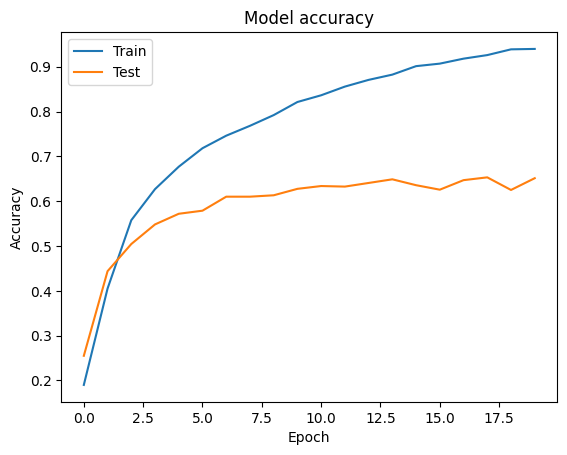

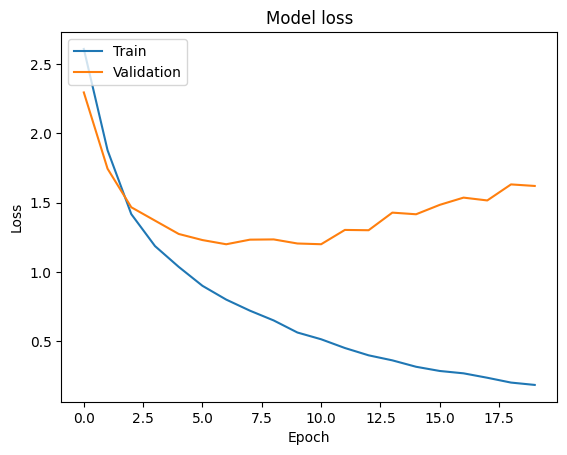

In [40]:
# Plotting the training and validation accuracy values over epochs

# Step 1: Plotting Accuracy
# Plot the training accuracy values stored in 'accuracy' and validation accuracy values stored in 'val_accuracy' from history object
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

# Step 2: Plotting Loss
# Plot the training loss values stored in 'loss' and validation loss values stored in 'val_loss' from history objectplt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

### Other Evaluation Metrics used for Model Evaluation

The classification report includes precision, recall, and F1-score for each class, as well as support (the number of true instances for each class). The overall F1 score is calculated as the weighted average of F1 scores across all classes.

In [49]:
from sklearn.metrics import classification_report, f1_score

# Convert one-hot encoded predictions to class labels
pred_labels = label_encoder.inverse_transform(pred)

# Print classification report
print("Classification Report:\n", classification_report(test_y, pred_labels))

# Calculate and print overall F1 score
overall_f1 = f1_score(test_y, pred_labels, average='weighted')
print("Overall F1 Score:", overall_f1)


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       134
           1       0.85      0.89      0.87       194
           2       0.78      0.80      0.79       162
           3       0.70      0.75      0.72       150
           4       0.77      0.88      0.82       153
           5       0.76      0.72      0.74        39
           6       0.85      0.90      0.87       291
           7       0.00      0.00      0.00         1
           8       0.79      0.86      0.82       211
           9       0.89      0.83      0.86        47
          10       0.55      0.50      0.52        22
          11       0.65      0.67      0.66       134
          12       0.56      0.69      0.62        32
          13       0.80      0.95      0.87       201
          14       0.84      0.88      0.86       210
          15       0.80      0.76      0.78        51
          16       0.75      0.73      0.74       108
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Results Summary with Plotly Table
* The table includes precision, recall, F1-score, and support for each class, as well as an overall accuracy score. 

In [60]:
import plotly.graph_objects as go

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
})

# Add a row for overall accuracy
overall_row = pd.DataFrame({
    'Class': ['Overall'],
    'Precision': [precision.mean()],
    'Recall': [recall.mean()],
    'F1 Score': [f1_score(test_y, pred_labels, average='weighted')],
    'Support': [len(test_y)]
})
results_df = pd.concat([results_df, overall_row], ignore_index=True)

# Create a Plotly figure for the table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(results_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[results_df[col] for col in results_df.columns],
               fill_color='lavender',
               align='left'))
])

# Update layout for a more compact and appealing appearance
fig.update_layout(width=800, height=450, margin=dict(l=10, r=10, b=10, t=10))

# Display the table
fig.show()

# Print overall accuracy
print("\nOverall Accuracy:", accuracy)



Overall Accuracy: 0.757453073242547
